In [1]:
import time
time.ctime()

'Fri Dec 21 18:08:46 2018'

Dieses IPython-Notebook basiert auf einer Beispiel-Rechnung als Ergänzung zur [Dissertationsschrift von C. Knoll](http://www.qucosa.de/fileadmin/data/qucosa/documents/20976/knoll_dissertation_digital.pdf). Allgemeine Hinweise zu den Beispielen sind in der [readme.md-Datei des entsprechenden Repositoriums](https://github.com/cknoll/beispiele/blob/master/readme.md) zu finden.

Dieses Notebook benötigt folgende Module (am einfachsten per `pip install <modulname>` zu installieren):
* sympy
* https://github.com/TUD-RST/symbtools
* https://github.com/cknoll/ipydex


---

**Betrachtetes System**: Ein Pendel mit horizontal verschieblicher Aufhängung ("Wagen-Pendel-System")

￼ <img src="files/images/pendel_wagen.png">

**Inhalt**:
* Herleitung der Modellgleichungen in partiell linearisierter Form
* Transformation in Byrnes-Isidori-Normalform

**Bemerkung**

Das Notebook dient zur Demonstration, dass die rechenaufwendigen Transformationen sehr von einem Computer-Algebra-System (CAS) durchgeführt werden können. Im vorliegenden fall wird `sympy` als CAS verwendet. Im Paket `symbtools` und speziell in dessen Modul `modeltools` ist die Funktionalität für die Transformationen implementiert (Siehe dessen Quelltext).
Die verwendete Notation erklärt sich folgendermaßen: $\theta_i$ bezeichnet alle Konfigurationskoordinaten, $p_i$ die nicht-aktuierten und $q_i$ die aktuierten (jeweils für passende Werte von $i$).


[//]: # (custom_config_start)
$$
\newcommand{\d}{\mathrm{d}}
\newcommand{\col}{\mathrm{col}}
\newcommand{\bs}{\boldsymbol}
\newcommand{\Ddt}{\left(\tfrac{d}{dt}\right)}
\newcommand{\ddt}{\tfrac{d}{dt}}
$$

[//]: # (custom_config_end)

In [2]:
%load_ext ipydex.displaytools
%matplotlib inline

import sympy as sp
from sympy import sin, cos, pi
from sympy.interactive import printing
import pickle
from scipy.integrate import odeint

import symbtools as st
import symbtools.modeltools as mt
import symbtools.noncommutativetools as nct

zip0 = st.zip0
printing.init_printing(1)

In [3]:
t = sp.Symbol('t')
Np = 1
Nq = 1
n = Np + Nq
pp = st.symb_vector("p1:{0}".format(Np+1))
qq = st.symb_vector("q1:{0}".format(Nq+1))
aa = st.symb_vector("a1:{0}".format(Nq+1))
ww = st.symb_vector("w1:{0}".format(Nq+1))

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad, tthetadd)

---


---


---


In [4]:
# Systemparameter und virtueller Eingang (wird später gebraucht)
params = sp.symbols('m1, m2, s2, g, v')
st.make_global(params)

tau1 = sp.Symbol("tau1")

### Festlegung der Geometrie des mechanischen Systemes

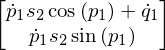

---


In [5]:
#Einheitsvektoren

ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])


# Koordinaten der Schwerpunkte und Gelenke

S1 = ex*q1 # Schwerpunkt Wagen
G2 = S1 # Pendel-Gelenk

# Schwerpunkt des Pendels (Pendel zeigt für kleine Winkel nach unten)
S2 = G2 + mt.Rz(p1)*(-ey)*s2

# Zeitableitungen der Schwerpunktskoordinaten
Sd1, Sd2  = st.col_split(st.time_deriv(st.col_stack(S1, S2), ttheta)) ##

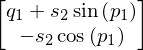

In [6]:
S2

In [7]:
# Energie
T_rot = 0 # (Punktmassenmodell)
T_trans = ( m1*Sd1.T*Sd1  +  m2*Sd2.T*Sd2 )/2

T = T_rot + T_trans[0]

V = m2*g*S2[1]

In [8]:
mod = mt.generate_symbolic_model(T, V, ttheta, [0, tau1])

### Modellgleichungen in der Form $M(\theta) \ddot{\theta} + C(\theta, \dot \theta) + K(\theta, \dot \theta) -
\left(\begin{smallmatrix}
 0 \\
1
\end{smallmatrix} \right) \tau
$ = 0

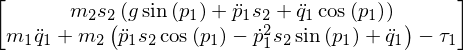

In [9]:
mod.eqns

In [10]:
# Zustandsdarstellung berechnen (= hauptsächlich Massenmatrix invertieren)
mod.calc_state_eq()

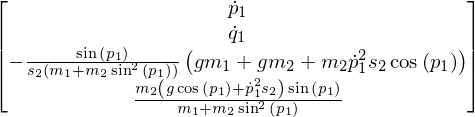

___


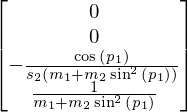

___


In [11]:
mod.f ##:
mod.g ##:

In [12]:
xx = st.symb_vector('x1:5') # Andere Symbole für Zustandskomponenten

if 0:
    # Latex-Code  für die Übung (ggf. überspringen)
    st.adapted_latex(mod.f.subz(mod.xx, xx))
    st.adapted_latex(mod.g.subz(mod.xx, xx))


### Kollokierte partielle Eingangs-Zustands-Linearisierung
(entspricht Eingangsausgangslinearisierung bezüglich des Ausgangs $y = q $ ("aktuierte Koordinaten"))

In [13]:
# Betimmung und Einsetzen der Zustandsabhängigen Eingangstransformation.

mod.calc_coll_part_lin_state_eq()

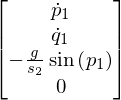

___


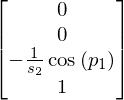

___


In [14]:
mod.ff ##:
mod.gg ##:

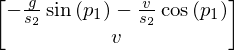

---


In [15]:
# 2x1 Vektor der Beschleunigungen in Abhänghigkeit von v

acc = mod.ff[2:, :] + mod.gg[2:, :]*v ##:

### Berechnung der Byrnes-Isidori-Normalform

Zur Illustration werden hier die Zwischenerbgenisse angegeben:

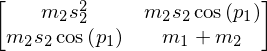

___


---


---


In [16]:
mod.M ##:

M11 = mod.M[:Np,:Np] ##:
M12 = mod.M[Np:,:Np] ##:

Einführung der neuen Zustandskomponente (deren Ableitung per Konstruktion unabhängig vom Eingang ist).
$w = \dot  \theta_1 + M_{11}^{-1}M_{12} \theta_2$

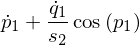

---


In [17]:
w4 = tthetad[0] + (M11.inv()*M12)[0]*tthetad[1] ##:

Bildung der Ableitung

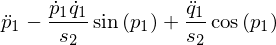

---


In [18]:
w4d = st.time_deriv(w4, ttheta) ##:

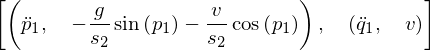

---


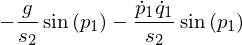

---


In [19]:
# Beschleunigungen Ersetzen:

replmts = list(zip(tthetadd, acc)) ##:
w4d_ = w4d.subs(replmts) ##:

-> Die Abhängigkeit von $v$ hat sich gegenseitig aufgehoben (wie zu erwarten). Zur Angabe der Systemdynamik in den Koordinaten der BI-NF muss jetzt nur noch die Umkehrtransformation eingesetzt werden. Dazu müssen die Transformationen zunächst ordentlich aufgeschrieben werden




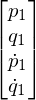

---


In [20]:
# bisheriger Zustandsvektor
xx_ = mod.xx ##:

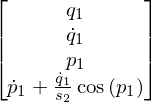

---


In [21]:
# neuer Zustandsvektor
Phi = sp.Matrix([xx_[1], xx_[3], xx_[0], w4]) ##:

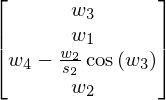

---


In [22]:
# Umkehrtransformation durch algebraisches Auflösen
ww = st.symb_vector('w1:5')

Psi = sp.Matrix(sp.solve(Phi-ww, xx_)[0]) ##:


Jetzt kann man $\dot z$ zunächst in gemischten bzw. alten Koordinaten berechnen und dann die Beschleunigungn und dann Rücktransformation einsetzen.

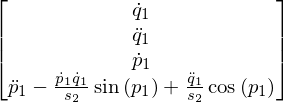

---


In [23]:
w_dot_mixed_coordinates1 = st.time_deriv(Phi, ttheta) ##:

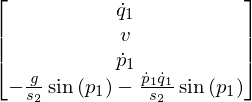

---


In [24]:
# Beschleunigungen einsetzen -> v hebt sich raus, siehe oben
w_dot_mixed_coordinates2 = w_dot_mixed_coordinates1.subz(tthetadd, acc) ##:

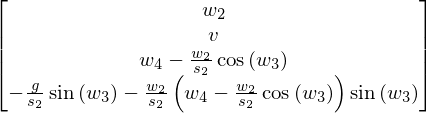

---


In [25]:
w_dot = w_dot_mixed_coordinates2.subz(xx_, Psi) ##:

Die ganze Funktionalität ist auch in der Methode `mod.calc_coll_part_lin_state_eq` hinterlegt. Einziger Unterschied: Benennung der Zustandskomponenten.

In [26]:
mod.calc_coll_part_lin_state_eq()

In [27]:
mod.fz ##:
mod.gz ##:

mod.fz  := None

___


mod.gz  := None

___
